# RANS from DNS

Our goal here, in general, is to find new valid equations that describe fluid flow. 
We will try to find new closures for the steady RANS equations based on direct numerical
simulation (DNS) of a boundary layer.


## Steady RANS equations with generic Reynolds stress effects

$$
(\vec{U} \cdot \nabla) \vec{U}
+ \frac{1}{\rho} \nabla P 
- \nu \nabla^2 \vec{U}
= \mathbf{R},
$$

where in this case $\mathbf{R}$ is simply the effects of the Reynolds stresses (i.e., the opposite of the gradient), not the Reynolds stresses themselves.

Some ideas for what $\mathbf{R}$ could be:

$$
\mathbf{R} = A\nabla P^2 + B\nabla K + C \nabla \times \vec{U} 
    + D\nabla(\nabla \times \vec{U})^2
    + E \vec{U}
$$


## Algorithm

1. Pick terms (in addition to non-Reynolds stress Navier--Stokes terms).
2. Create a random list of points in space that is at least as large as the number
   of terms.
3. At each point, acquire all data for all terms for all times.
4. Average data at each point for all times.
5. Solve for coefficients using a linear model.

## Terms

$$
U \frac{\partial U}{\partial x} 
+ V \frac{\partial U}{\partial y} + W \frac{\partial U}{\partial z}
+ \frac{1}{\rho}\frac{\partial P}{\partial x} 
- \nu \left( 
    \frac{\partial^2 U}{\partial x^2}
    + \frac{\partial^2 U}{\partial y^2} 
    + \frac{\partial^2 U}{\partial z^2} 
\right)
$$

$$
= 
A \left( \frac{\partial U}{\partial x} \right)^2 
+ B \left( \frac{\partial U}{\partial y} \right)^2
+ C \left( \frac{\partial U}{\partial z} \right)^2
+ D \left( \frac{\partial P}{\partial x} \right)^2
+ E \frac{\partial^2 P}{\partial x^2}
+ F U \frac{\partial P}{\partial x}
$$

$$
U \frac{\partial V}{\partial x} 
+ V \frac{\partial V}{\partial y} 
+ W \frac{\partial V}{\partial z}
+ \frac{1}{\rho}\frac{\partial P}{\partial y} 
- \nu \left( 
    \frac{\partial^2 V}{\partial x^2}
    + \frac{\partial^2 V}{\partial y^2} 
    + \frac{\partial^2 V}{\partial z^2} 
\right)
$$

$$
= 
A \left( \frac{\partial V}{\partial x} \right)^2 
+ B \left( \frac{\partial V}{\partial y} \right)^2
+ C \left( \frac{\partial V}{\partial z} \right)^2
+ D \left( \frac{\partial P}{\partial y} \right)^2
+ E \frac{\partial^2 P}{\partial y^2}
+ F V \frac{\partial P}{\partial y}
$$

## Terms in index notation

To be general and consistent, since we don't have any x- or z-variation

$$
\frac{\partial U_i}{\partial t} + U_j \frac{\partial U_i}{\partial x_j} 
+ \frac{1}{\rho}\frac{\partial P}{\partial x_i}
- \nu \frac{\partial ^2 U_i}{\partial x_j x_j}
=
A \frac{(\partial U_i)^2}{\partial x_j \partial x_j}
+ B \frac{\partial U_j U_j}{\partial x_i}
+ C \frac{\partial P^2}{\partial x_i}
+ D \left( \frac{\partial P}{\partial x_i} \right)^2
+ E U_j \frac{\partial P}{\partial x_j}
$$

What these coefficients describe:

* $A$: The square of the velocity gradient
* $B$: The gradient of kinetic energy
* $C$: The gradient of squared pressure
* $D$: The square of the pressure gradient

Other possible quantities
* Absolute distance from a solid boundary

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use("nbAgg")

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn
import jhtdb
seaborn.set()

%matplotlib inline

## Using data from pyJHTDB

1. Pick a bunch of points randomly throughout the domain, at least more than the number of terms we want to test.
2. Add points in each direction for computing spatial derivatives.
3. Get $\vec{u}$, $p$, and their gradients for all time at all points in the list.
4. Calculate terms based on mean values.
5. Use a regression model to determine coefficients on each term.
6. Repeat this process to ensure the coefficients don't change?
7. Run a RANS simulation with this new model and check the results against the mean profiles.

In [3]:
df = jhtdb.read_stats()

In [11]:
# Let's check continuity
div = df["dudx"] + df["dvdy"] + df["dwdz"]
div.describe()

count    100.000000
mean       0.000020
std        0.000220
min       -0.000722
25%       -0.000015
50%        0.000001
75%        0.000043
max        0.000913
dtype: float64

The check above gives us an idea on how accurate these gradient calculations
are.

In [12]:
df.columns

Index(['p', 'pp', 'u', 'up', 'uu', 'uv', 'uw', 'v', 'vp', 'vv', 'vw', 'w',
       'wp', 'ww', 'dpdx_fd', 'duudx_fd', 'duvdy_fd', 'dudx_fd', 'dudy_fd',
       'd2udx2_fd', 'd2udy2_fd', 'dpdy_fd', 'd2udx2', 'd2udxdy', 'd2udy2',
       'd2udz2', 'd2udxdz', 'd2udydz', 'd2vdx2', 'd2vdxdy', 'd2vdxdz',
       'd2vdy2', 'd2vdydz', 'd2vdz2', 'd2wdx2', 'd2wdxdy', 'd2wdxdz', 'd2wdy2',
       'd2wdydz', 'd2wdz2', 'd2pdx2', 'd2pdxdy', 'd2pdxdz', 'dp2dy2',
       'd2pdydz', 'd2pdz2', 'dudx', 'dudy', 'dudz', 'dvdx', 'dvdy', 'dvdz',
       'dwdx', 'dwdy', 'dwdz', 'dpdx', 'dpdy', 'dpdz'],
      dtype='object')

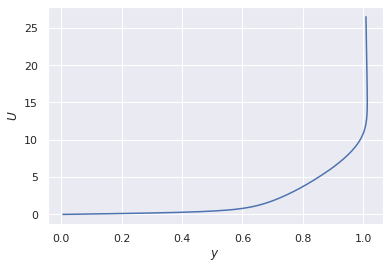

In [13]:
ax = (
    df.loc[df.index.get_level_values("x")[-1000]]
    .reset_index()
    .plot(x="u", y="y", legend=False, ylabel="$U$", xlabel="$y$")
)



In [ ]:
# TODO: Compute a bunch of quantities and add to the data dictionary
# Mean kinetic energy
# Squared gradients
# Gradients multiplied by each other
# Gradients multiplied by mean values

In [ ]:
# Compute the Reynolds stress residual as a target for an ML model
# Solve a linear regression for the coefficients of all derived terms
# Throw out terms with coefficients below a threshold

In [ ]:
# TODO: Write as a RANS model for OpenFOAM and solve this same problem there
# First run a baseline case with a high Re kOmegaSST model
# How to handle wall functions?

In [ ]:
# TODO: Check mean flow from OpenFOAM simulation matches DNS